# Preparation

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [283]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.model_selection import train_test_split

from torch.utils.data import TensorDataset, DataLoader
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from torch.utils.data.sampler import WeightedRandomSampler
from torch.optim import lr_scheduler

from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from transformers import AdamW, get_linear_schedule_with_warmup


from fetchData import fetchdata 
import random

In [284]:
if torch.cuda.is_available():       
    device = torch.device("cuda")
    print(f'There are {torch.cuda.device_count()} GPU(s) available.')
    print('Device name:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

No GPU available, using the CPU instead.


In [285]:
pheme_w2v = pd.read_csv('./data/_PHEME_text_AVGw2v.csv').drop(['token'],axis=1)
pheme_y = pd.read_csv('./data/_PHEME_target.csv').target
pheme_sparse = pd.read_csv('./data/_PHEME_sparse.csv')
pheme_event = pd.read_csv('./data/_PHEME_text.csv').Event

ext_w2v = pd.read_csv('./data/_PHEMEext_text_AVGw2v.csv').drop(['token'],axis=1)
ext_y = pd.read_csv('./data/_PHEMEext_text.csv').target
ext_sparse = pd.read_csv('./data/_PHEMEext_sparse.csv')
ext_event = pd.read_csv('./data/_PHEMEext_text.csv').Event

rhi = pd.read_csv('./data/_RHI_text_AVGw2v.csv').drop(['token'],axis=1)
rhi_y = pd.read_csv('./data/_RHI_target.csv')

pheme_bert = fetchdata('pheme','bert')
ext_bert = fetchdata('ext','bert')
rhi_bert = fetchdata('rhi','bert')

In [286]:
def cv_events(data):
    NUM_EVENT = data.Event.unique().shape[0]
    EVENTS = data.Event.unique()

    cv_pd_list = []
    for i, d in enumerate(EVENTS):
        df1, df2 = [x for _, x in data.groupby(data['Event'] != d)]
        df1.reset_index(inplace=True, drop=True)
        df2.reset_index(inplace=True, drop=True)
        cv_pd_list.append([df1, df2])
    return cv_pd_list
cv = cv_events(pd.concat([pheme_sparse, pheme_y, pheme_event],axis=1))
X = cv[3][1].drop(['target', 'Event'],axis=1)
y = cv[3][1].target
val_X = cv[3][0].drop(['target', 'Event'],axis=1)
val_y = cv[3][0].target

In [287]:
pheme_sparse.verified = pheme_sparse.verified.replace({True: 1, False: 0}) 
ext_sparse.verified = ext_sparse.verified.replace({True: 1, False: 0}) 
pheme_sparse.has_question = pheme_sparse.has_question.replace({True: 1, False: 0}) 
ext_sparse.has_question = ext_sparse.has_question.replace({True: 1, False: 0}) 
pheme_sparse.has_exclaim = pheme_sparse.has_exclaim.replace({True: 1, False: 0}) 
ext_sparse.has_exclaim = ext_sparse.has_exclaim.replace({True: 1, False: 0}) 
pheme_sparse.has_period = pheme_sparse.has_period.replace({True: 1, False: 0}) 
ext_sparse.has_period = ext_sparse.has_period.replace({True: 1, False: 0}) 

## Functions

In [297]:
def clf_report(train_loss, train_acc, val_loss, val_acc):
    fig, ax = plt.subplots(4, 1, figsize=(12,8))
    ax[0].plot(train_loss[:])
    ax[0].set_ylabel('Loss')
    ax[0].set_title('Training Loss')

    ax[1].plot(train_acc[:])
    ax[1].set_ylabel('Classification Accuracy')
    ax[1].set_title('Training Accuracy')

    ax[2].plot(val_loss[:])
    ax[2].set_ylabel('Classification Accuracy')
    ax[2].set_title('Testing Loss')

    ax[3].plot(val_acc[:])
    ax[3].set_ylabel('Classification Accuracy')
    ax[3].set_title('Testing Accuracy')

    plt.tight_layout()
    plt.show()

    print("Min of Training Loss: %4f"%(np.min(train_loss)))
    print("Max of Training Accuracy: %4f"%(np.max(train_acc)))
    print("Mean of Training Loss: %4f"%(np.mean(train_loss)))
    print("Mean of Training Accuracy: %4f"%(np.mean(train_acc)))
    print("----")
    print("Max of Testing Accuracy: %4f"%(np.max(val_acc)))
    print("Mean of Testing Loss: %4f"%(np.mean(val_loss_list)))
    print("Mean of Testing Accuracy: %4f"%(np.mean(val_acc)))

def set_seed(seed_value=42):
    """Set seed for reproducibility.
    """
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)



def train1(model, num_epochs, criterion, optimizer, train_loader, train_size, test_loader=None, test_size=None, patience=5, PATH='./state_dict_model.pt'):
    set_seed(42)
    train_loss = []
    patience_count = 0
    train_accuracy = []
    prev_loss = 10
    best_loss = 10.0
    val_corrects_list = []
    val_loss_list = []
    val_acc_list = []
    for epoch in range(num_epochs):  # loop over the dataset multiple times
        # print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        # print('-' * 10)
        running_corrects = 0.0
        running_loss = 0.0
        model.train()  # Set model to training mode
        for i, data in enumerate(train_loader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            inputs, labels = inputs.float(), labels.float()

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(inputs)

            #  _, predictions = torch.max(outputs.data, 1) won’t work if your output only contains a single output unit.
            # _, preds = torch.max(outputs, 1)
            # print(outputs.flatten().size())
            preds = outputs.squeeze(1) > 0.0

            loss = criterion(outputs, labels.unsqueeze(1))
            loss.backward()
            optimizer.step()

            # step function
            scheduler.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / train_size
        # print(running_loss)
        # print(train_size)
        epoch_acc = running_corrects.double() / train_size
        train_loss.append(epoch_loss)
        train_accuracy.append(epoch_acc)

        if (epoch % 2 == 0):
            print('Epoch {}/{}\tTrain) Acc: {:.4f}, Loss: {:.4f}'.format(epoch,
                                                                         num_epochs - 1, epoch_acc, epoch_loss))

        if (test_loader != None):
            model.eval()
            with torch.no_grad():
                val_loss = 0.0
                val_corrects = 0
                val_preds_list = []
                val_label_list = []
                for j, val in enumerate(test_loader, 0):
                    val_x, val_label = val
                    val_x, val_label = val_x.float(), val_label.float()
                    val_outputs = model(val_x)
                    # _, val_preds = torch.max(val_outputs, 1)
                    val_preds = val_outputs.squeeze(1) > 0.0

                    val_preds_list.append(val_preds)
                    val_label_list.append(val_label)
                    v_loss = criterion(val_outputs, val_label.unsqueeze(1))
                    val_loss += (v_loss.item() * val_x.size(0))
                    val_corrects += torch.sum(val_preds == val_label)
                    # accuracy = (preds == b_labels).cpu().numpy().mean() * 100

                if (epoch % 2 == 0):
                    val_preds_list = torch.cat(val_preds_list, 0)
                    val_label_list = torch.cat(val_label_list, 0)
                    # print("\t\tValidation) Acc: {:.4f} Loss:{:.4f} F1 score: {:4f}".format(val_corrects/test_size, val_loss/test_size, f1_score(val_label_list,val_preds_list,average='macro')))
                    print("\t\tValidation) Acc: {:.4f} Loss:{:.4f}".format(
                        val_corrects/test_size, val_loss/test_size))
            val_corrects_list.append(val_corrects/test_size)
            val_loss_list.append(val_loss/test_size)
            val_acc = val_corrects.double() / test_size
            val_acc_list.append(val_acc)

        if epoch_loss < best_loss:
            # print("prev_loss: {:.5f}".format(prev_loss))
            # print("loss: {:.5f}".format(loss))
            print(
                "\t\tSaving the best model w/ loss {:.4f}".format(epoch_loss))
            torch.save(model.state_dict(), PATH)
            best_loss = epoch_loss
            patience_count = 0
        elif best_loss < epoch_loss:
            patience_count += 1
        if patience_count >= patience:
            print("Finishing the Model: Loss is not decreasing...")
            print(train_loss[-6:-1])
            return train_accuracy, train_loss, val_acc_list, val_loss_list
    return train_accuracy, train_loss, val_acc_list, val_loss_list

def train2(model, num_epochs, criterion, optimizer, train_loader, train_size, test_loader=None, test_size=None, patience=5, PATH='./state_dict_model.pt'):
    set_seed(42)
    train_loss = []
    patience_count = 0
    train_accuracy = []
    prev_loss = 10
    best_loss = 10.0
    val_corrects_list = []
    val_loss_list = []
    val_acc_list = []
    for epoch in range(num_epochs):  # loop over the dataset multiple times
        # print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        # print('-' * 10)
        running_corrects = 0.0
        running_loss = 0.0
        model.train()  # Set model to training mode
        for i, data in enumerate(train_loader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            inputs, labels = inputs.float(), labels.float()
            print(inputs.size())
            print(labels.size())
            print(inputs.flatten())
            print(labels.flatten())

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(inputs)
            print("outputs:",outputs.size())
            print("outputs:",outputs)
            print("labels:",labels.size())
            print("labels:",labels.unsqueeze(1).size())

            #  _, predictions = torch.max(outputs.data, 1) won’t work if your output only contains a single output unit.
            # _, preds = torch.max(outputs, 1)
            preds = torch.argmax(outputs, dim=1).flatten()
            # print(outputs.flatten().size())
            # preds = outputs > 0.0
            # labels = labels.view(-1)
            loss = criterion(outputs, labels.long())
            loss.backward()
            optimizer.step()

            # step function
            scheduler.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
            # print('running correct')
            # print(running_corrects)

        epoch_loss = running_loss / train_size
        # print(running_loss)
        # print(train_size)
        epoch_acc = running_corrects.double() / train_size
        train_loss.append(epoch_loss)
        train_accuracy.append(epoch_acc)

        if (epoch % 2 == 0):
            print('Epoch {}/{}\tTrain) Acc: {:.4f}, Loss: {:.4f}'.format(epoch,
                                                                         num_epochs - 1, epoch_acc, epoch_loss))

        if (test_loader != None):
            model.eval()
            with torch.no_grad():
                val_loss = 0.0
                val_corrects = 0
                val_preds_list = []
                val_label_list = []
                for j, val in enumerate(test_loader, 0):
                    val_x, val_label = val
                    val_x, val_label = val_x.float(), val_label.float()
                    val_outputs = model(val_x)
                    val_preds = torch.argmax(val_outputs, dim=1).flatten()
                    # _, val_preds = torch.max(val_outputs, 1)
                    # print("val_outputs:",val_outputs.flatten())
                    # val_preds = val_outputs > 0.0
                    # print("val_preds:",val_preds)
                    val_preds_list.append(val_preds)
                    val_label_list.append(val_label)
                    v_loss = criterion(val_outputs, val_label.unsqueeze(1))
                    val_loss += (v_loss.item() * val_x.size(0))
                    val_corrects += torch.sum(val_preds ==
                                              val_label.data).double()
                if (epoch % 2 == 0):
                    val_preds_list = torch.cat(val_preds_list, 0)
                    val_label_list = torch.cat(val_label_list, 0)
                    # print("\t\tValidation) Acc: {:.4f} Loss:{:.4f} F1 score: {:4f}".format(val_corrects/test_size, val_loss/test_size, f1_score(val_label_list,val_preds_list,average='macro')))
                    print("\t\tValidation) Acc: {:.4f} Loss:{:.4f}".format(
                        val_corrects/test_size, val_loss/test_size))
            val_corrects_list.append(val_corrects/test_size)
            val_loss_list.append(val_loss/test_size)
            val_acc = val_corrects.double() / test_size
            val_acc_list.append(val_acc)

        if epoch_loss < best_loss:
            # print("prev_loss: {:.5f}".format(prev_loss))
            # print("loss: {:.5f}".format(loss))
            print(
                "\t\tSaving the best model w/ loss {:.4f}".format(epoch_loss))
            torch.save(model.state_dict(), PATH)
            best_loss = epoch_loss
            patience_count = 0
        elif best_loss < epoch_loss:
            patience_count += 1
        if patience_count >= patience:
            print("Finishing the Model: Loss is not decreasing...")
            print(train_loss[-6:-1])
            return train_accuracy, train_loss, val_acc_list, val_loss_list
    return train_accuracy, train_loss, val_acc_list, val_loss_list

def predict(model, criterion, val_dataloader, val_size):
    model.eval()
    with torch.no_grad():
        val_loss = 0.0
        val_corrects = 0
        for j, val in enumerate(val_dataloader, 0):
            val_x, val_label = val
            val_x, val_label = val_x.float(), val_label.float()
            val_outputs = model(val_x)
            val_preds = val_outputs.squeeze(1) > 0.0

            val_preds_list.append(val_preds)
            val_label_list.append(val_label)
            v_loss = criterion(val_outputs, val_label.unsqueeze(1))
            val_loss += (v_loss.item() * val_x.size(0))
            val_corrects += torch.sum(val_preds == val_label)

    val_preds_list = torch.cat(val_preds_list, 0)
    val_label_list = torch.cat(val_label_list, 0)
    val_corrects = val_corrects/val_size
    val_loss/test_size
    val_acc = val_corrects.double() / val_size
    print("\t\tValidation) Acc: {:.4f} Loss:{:.4f}".format(
        val_corrects/val_size, val_loss/test_size))
    # print("\t\tValidation) Acc: {:.4f} Loss:{:.4f} F1 score: {:4f}".format(val_corrects/val_size, val_loss/test_size, f1_score(val_label_list,val_preds_list,average='macro')))


In [219]:
val_accuracy = []
val_accuracy.append([1,2,3])
val_accuracy.append([1,2,3])
val_accuracy = np.mean(val_accuracy)
val_accuracy

2.0

# Sparse-MLP

In [62]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
train = scaler.fit_transform(pheme_sparse.values)
test = scaler.fit_transform(ext_sparse.values)

In [63]:
# tensor_x1 = torch.Tensor(pheme_sparse.values).unsqueeze(1)
tensor_x1 = torch.Tensor(train).unsqueeze(1)
tensor_y1 = torch.Tensor(pheme_y.values).unsqueeze(1)
train_dataset = TensorDataset(tensor_x1,tensor_y1)

# tensor_x2 = torch.Tensor(ext_sparse.values).unsqueeze(1)
tensor_x2 = torch.Tensor(test).unsqueeze(1)
tensor_y2 = torch.Tensor(ext_y.values).unsqueeze(1)
test_dataset = TensorDataset(tensor_x2,tensor_y2)


# For fine-tuning BERT, the authors recommend a batch size of 16 or 32.
batch_size = 32

# Initialize WeightedRandomSampler to deal with the unbalanced dataset
counts = np.bincount(pheme_y.values)
labels_weights = 1. / counts
weights = labels_weights[pheme_y.values]
train_sampler = WeightedRandomSampler(weights, len(weights))
test_sampler = SequentialSampler(tensor_x2)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, sampler=train_sampler, num_workers=2)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

train_size = int(tensor_y1.size(0))
test_size = int(tensor_y2.size(0))
print(tensor_x1.shape)
print(tensor_y1.shape)
print("Train Size",train_size,"Test Size",test_size)

torch.Size([5802, 1, 27])
torch.Size([5802, 1])
Train Size 5802 Test Size 485


In [64]:
class sparse_model(nn.Module):
    def __init__(self):
        super(sparse_model, self).__init__() # 1*20
        self.fc1 = nn.Linear(27, 12, bias=True) # 420
        self.fc2 = nn.Linear(12, 8, bias=True)
        self.fc3 = nn.Linear(8, 1)

        self.drop_3 = nn.Dropout(0.3)
        self.drop_4 = nn.Dropout(0.4)
        self.drop_2 = nn.Dropout(0.2)

    def forward(self, x):
        x = self.drop_2(F.elu(self.fc1(x)))
        x = F.elu(self.fc2(x))
        x = self.fc3(x)
        return x

In [65]:
model_sparse = sparse_model()

criterion = nn.BCEWithLogitsLoss()
# optimizer = optim.SGD(model_sparse.parameters(), lr=0.01, momentum=0.9)
optimizer = optim.Adam(model_sparse.parameters(), lr=5e-5, eps=1e-8, weight_decay=1e-6)
# scheduler = lr_scheduler.ExponentialLR(optimizer, gamma= 0.99)  

epochs = 100

total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps=0,  # Default value
                                            num_training_steps=total_steps)

PATH = "./Model/state_dict_sparse_model.pt"

In [66]:
train_acc, train_loss, val_acc, val_loss_list = train1(model=model_sparse, num_epochs=100, criterion=criterion, optimizer=optimizer, train_loader=train_dataloader, train_size=train_size, test_loader=test_dataloader, test_size=test_size, PATH=PATH)

Epoch 0/99	Train) Acc: 0.5367, Loss: 0.6858
		Validation) Acc: 0.7423 Loss:0.6161
		Saving the best model w/ loss 0.6858
		Saving the best model w/ loss 0.6814
Epoch 2/99	Train) Acc: 0.5651, Loss: 0.6742
		Validation) Acc: 0.7464 Loss:0.6182
		Saving the best model w/ loss 0.6742
		Saving the best model w/ loss 0.6729
Epoch 4/99	Train) Acc: 0.5903, Loss: 0.6658
		Validation) Acc: 0.7402 Loss:0.6216
		Saving the best model w/ loss 0.6658
		Saving the best model w/ loss 0.6614
Epoch 6/99	Train) Acc: 0.6182, Loss: 0.6545
		Validation) Acc: 0.7072 Loss:0.6254
		Saving the best model w/ loss 0.6545
		Saving the best model w/ loss 0.6480
Epoch 8/99	Train) Acc: 0.6150, Loss: 0.6543
		Validation) Acc: 0.7072 Loss:0.6295
		Saving the best model w/ loss 0.6393
Epoch 10/99	Train) Acc: 0.6467, Loss: 0.6356
		Validation) Acc: 0.7010 Loss:0.6342
		Saving the best model w/ loss 0.6356
		Saving the best model w/ loss 0.6311
Epoch 12/99	Train) Acc: 0.6525, Loss: 0.6338
		Validation) Acc: 0.6948 Loss:0.

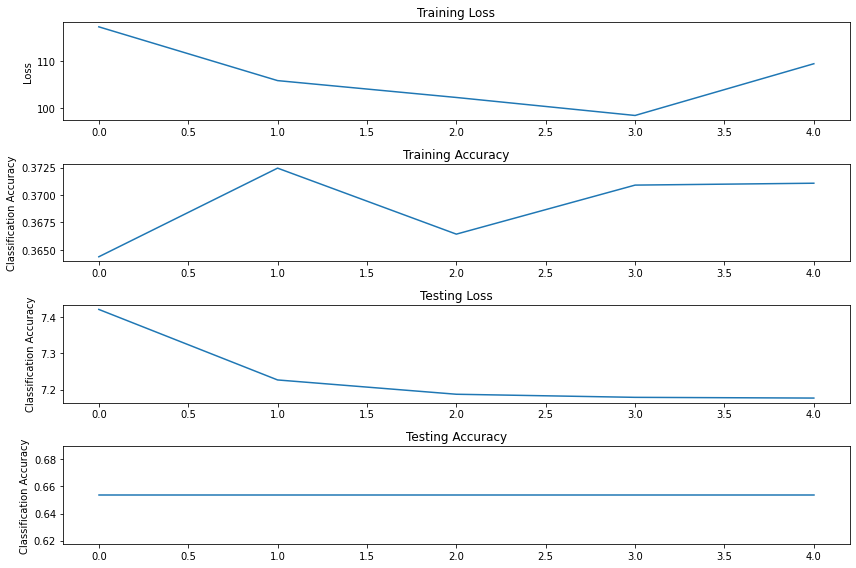

In [46]:
clf_report(train_loss, train_acc, val_loss_list, val_acc)

# W2V-MLP

In [21]:
tensor_x1 = torch.Tensor(pheme_w2v.values).unsqueeze(1)
tensor_y1 = torch.Tensor(pheme_y.values).unsqueeze(1)
train_dataset = TensorDataset(tensor_x1,tensor_y1)

tensor_x2 = torch.Tensor(ext_w2v.values).unsqueeze(1)
tensor_y2 = torch.Tensor(ext_y.values).unsqueeze(1)
test_dataset = TensorDataset(tensor_x2,tensor_y2)

In [22]:
# Initialize WeightedRandomSampler to deal with the unbalanced dataset
counts = np.bincount(pheme_y.values)
labels_weights = 1. / counts
weights = labels_weights[pheme_y.values]
train_sampler = WeightedRandomSampler(weights, len(weights))
test_sampler = SequentialSampler(tensor_x2)

batch_size = 16

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, sampler=train_sampler, num_workers=2)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

data = next(iter(train_dataloader))
print("mean: %s, std: %s" %(data[0].mean(), data[0].std()))

train_size = int(tensor_y1.size(0))
test_size = int(tensor_y2.size(0))
print(tensor_x1.shape)
print(tensor_y1.shape)
print("Train Size",train_size,"Test Size",test_size)

mean: tensor(-0.0106), std: tensor(0.2582)
torch.Size([5802, 1, 200])
torch.Size([5802, 1])
Train Size 5802 Test Size 485


In [23]:
class W2V_net(nn.Module):
    def __init__(self):
        super(W2V_net, self).__init__() # 1*20
        self.fc1 = nn.Linear(200, 32, bias=True) # 420
        self.fc2 = nn.Linear(32, 8, bias=True)
        self.fc3 = nn.Linear(8, 1)

        self.drop_3 = nn.Dropout(0.3)
        self.drop_4 = nn.Dropout(0.4)
        self.drop_2 = nn.Dropout(0.2)

    def forward(self, x):
        x = self.drop_2(F.elu(self.fc1(x)))
        x = self.drop_2(F.elu(self.fc2(x)))
        x = self.fc3(x)
        return x

In [26]:
model_w2v = W2V_net()

criterion = nn.BCEWithLogitsLoss()
# optimizer = optim.SGD(task1_model.parameters(), lr=0.001, momentum=0.9)
optimizer = optim.Adam(model_w2v.parameters(), lr=1e-5, weight_decay=1e-6)
# scheduler = lr_scheduler.ExponentialLR(optimizer, gamma= 0.99)  

train_loss = []
train_accuracy = []

epochs = 100

total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps=0,  # Default value
                                            num_training_steps=total_steps)

PATH = "./Model/state_dict_w2v_model.pt"

In [29]:
train_acc, train_loss, val_acc, val_loss_list = train1(model=model_w2v, num_epochs=40, criterion=criterion, optimizer=optimizer, train_loader=train_dataloader,train_size=train_size, test_loader=test_dataloader, test_size=test_size, PATH=PATH)

Epoch 0/39	Train) Acc: 0.4940, Loss: 0.7043
		Validation) Acc: 0.7608 Loss:0.6302
		Saving the best model w/ loss 0.7043
		Saving the best model w/ loss 0.6997
Epoch 2/39	Train) Acc: 0.4972, Loss: 0.6949
		Validation) Acc: 0.7608 Loss:0.6374
		Saving the best model w/ loss 0.6949
		Saving the best model w/ loss 0.6917
Epoch 4/39	Train) Acc: 0.4928, Loss: 0.6870
		Validation) Acc: 0.7608 Loss:0.6451
		Saving the best model w/ loss 0.6870
		Saving the best model w/ loss 0.6830
Epoch 6/39	Train) Acc: 0.5453, Loss: 0.6758
		Validation) Acc: 0.7649 Loss:0.6500
		Saving the best model w/ loss 0.6758
		Saving the best model w/ loss 0.6705
Epoch 8/39	Train) Acc: 0.6010, Loss: 0.6680
		Validation) Acc: 0.7732 Loss:0.6538
		Saving the best model w/ loss 0.6680
		Saving the best model w/ loss 0.6620
Epoch 10/39	Train) Acc: 0.6512, Loss: 0.6567
		Validation) Acc: 0.7608 Loss:0.6548
		Saving the best model w/ loss 0.6567
		Saving the best model w/ loss 0.6528
Epoch 12/39	Train) Acc: 0.6856, Loss: 0

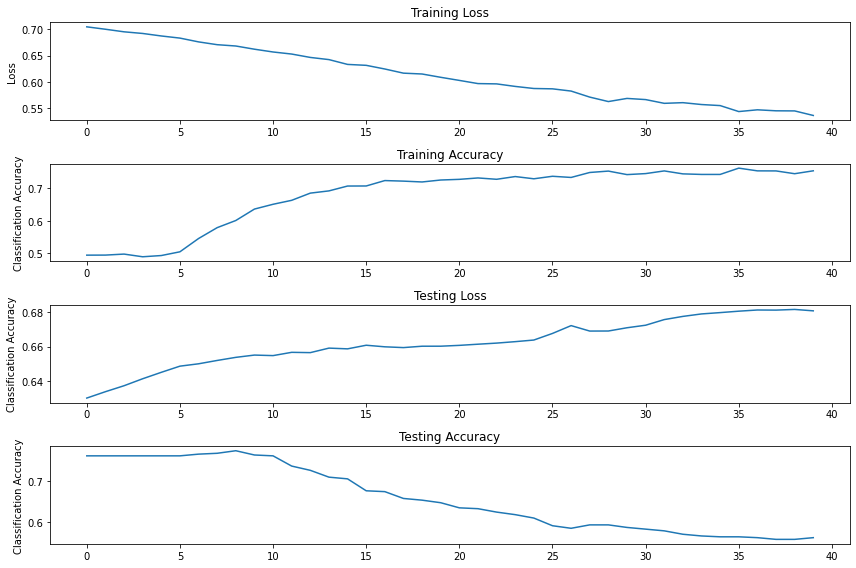

In [31]:
clf_report(train_loss, train_acc, val_loss_list, val_acc)

# BERT - MLP

In [15]:
tensor_x1 = torch.Tensor(pheme_bert.values).unsqueeze(1)
tensor_y1 = torch.Tensor(pheme_y.values).unsqueeze(1)
train_dataset = TensorDataset(tensor_x1,tensor_y1)

tensor_x2 = torch.Tensor(ext_bert.values).unsqueeze(1)
tensor_y2 = torch.Tensor(ext_y.values).unsqueeze(1)
test_dataset = TensorDataset(tensor_x2,tensor_y2)

In [16]:
# Initialize WeightedRandomSampler to deal with the unbalanced dataset
counts = np.bincount(pheme_y.values)
labels_weights = 1. / counts
weights = labels_weights[pheme_y.values]
train_sampler = WeightedRandomSampler(weights, len(weights))
test_sampler = SequentialSampler(tensor_x2)

batch_size = 32

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, sampler=train_sampler, num_workers=2)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

data = next(iter(train_dataloader))
print("mean: %s, std: %s" %(data[0].mean(), data[0].std()))

train_size = int(tensor_y1.size(0))
test_size = int(tensor_y2.size(0))
print(tensor_x1.shape)
print(tensor_y1.shape)
print("Train Size",train_size,"Test Size",test_size)


mean: tensor(0.0443), std: tensor(0.3106)
torch.Size([5802, 1, 768])
torch.Size([5802, 1])
Train Size 5802 Test Size 485


In [17]:
class BERT_net(nn.Module):
    def __init__(self):
        super(BERT_net, self).__init__() # 1*20
        self.fc1 = nn.Linear(768, 50, bias=True) # 420
        self.fc2 = nn.Linear(50, 8, bias=True)
        self.fc3 = nn.Linear(8, 1)

        self.drop_3 = nn.Dropout(0.3)
        self.drop_4 = nn.Dropout(0.4)
        self.drop_2 = nn.Dropout(0.2)

    def forward(self, x):
        x = self.drop_2(F.elu(self.fc1(x)))
        x = self.drop_2(F.elu(self.fc2(x)))
        x = self.fc3(x)
        return x

In [18]:
model_bert = BERT_net()
import torch.optim as optim

criterion = nn.BCEWithLogitsLoss()
# optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
optimizer = optim.Adam(model_bert.parameters(), lr=5e-5, eps=1e-8, weight_decay=1e-6)
# scheduler = lr_scheduler.ExponentialLR(optimizer, gamma= 0.99)  
train_loss = []
train_accuracy = []

epochs = 40

total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps=0,  # Default value
                                            num_training_steps=total_steps)

PATH = "./Model/state_dict_bert_model.pt"

In [19]:
train_acc, train_loss, val_acc, val_loss_list = train1(model=model_bert, num_epochs=epochs, criterion=criterion, optimizer=optimizer, train_loader=train_dataloader, train_size=train_size, test_loader=test_dataloader, test_size=test_size, PATH=PATH)

Epoch 0/39	Train) Acc: 0.7099, Loss: 0.5988
		Validation) Acc: 0.6515 Loss:0.7464
		Saving the best model w/ loss 0.5988
		Saving the best model w/ loss 0.5551
Epoch 2/39	Train) Acc: 0.7192, Loss: 0.5526
		Validation) Acc: 0.6495 Loss:0.8655
		Saving the best model w/ loss 0.5526
		Saving the best model w/ loss 0.5400
Epoch 4/39	Train) Acc: 0.7294, Loss: 0.5317
		Validation) Acc: 0.6474 Loss:0.9276
		Saving the best model w/ loss 0.5317
Epoch 6/39	Train) Acc: 0.7487, Loss: 0.5211
		Validation) Acc: 0.6247 Loss:0.9293
		Saving the best model w/ loss 0.5211
Epoch 8/39	Train) Acc: 0.7454, Loss: 0.5243
		Validation) Acc: 0.6124 Loss:0.9327
		Saving the best model w/ loss 0.5103
Epoch 10/39	Train) Acc: 0.7518, Loss: 0.5157
		Validation) Acc: 0.6062 Loss:0.9477
Epoch 12/39	Train) Acc: 0.7575, Loss: 0.5115
		Validation) Acc: 0.5979 Loss:0.9483
		Saving the best model w/ loss 0.5082
Epoch 14/39	Train) Acc: 0.7497, Loss: 0.5247
		Validation) Acc: 0.5876 Loss:0.9500
		Saving the best model w/ lo

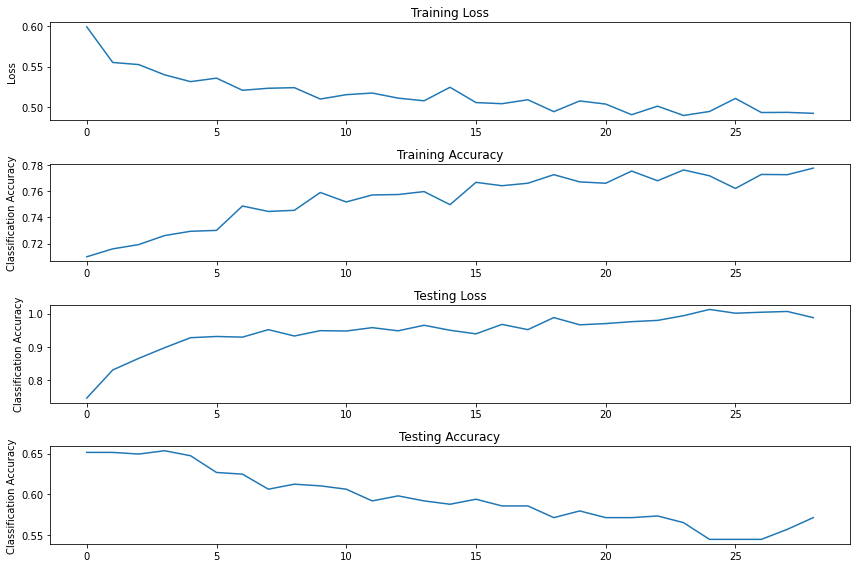

In [20]:
clf_report(train_loss, train_acc, val_loss_list, val_acc)

# Sparse + W2V -> MLP

In [221]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
pheme_sparse = scaler.fit_transform(pheme_sparse.values)
sparse_bert = np.concatenate([pheme_sparse, pheme_bert.values],axis=1)
ext_sparse = scaler.fit_transform(ext_sparse.values)
sparse_bert_ext = np.concatenate([ext_sparse, ext_bert.values],axis=1)

In [223]:
tensor_x1 = torch.Tensor(Train).unsqueeze(1)
tensor_y1 = torch.Tensor(pheme_y.values).unsqueeze(1)
train_dataset = TensorDataset(tensor_x1,tensor_y1)

tensor_x2 = torch.Tensor(Test).unsqueeze(1)
tensor_y2 = torch.Tensor(ext_y.values).unsqueeze(1)
test_dataset = TensorDataset(tensor_x2,tensor_y2)

In [224]:
# Initialize WeightedRandomSampler to deal with the unbalanced dataset
counts = np.bincount(pheme_y.values)
labels_weights = 1. / counts
weights = labels_weights[pheme_y.values]
train_sampler = WeightedRandomSampler(weights, len(weights))
test_sampler = SequentialSampler(tensor_x2)

batch_size=32

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, sampler=train_sampler, num_workers=2)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

data = next(iter(train_dataloader))
print("mean: %s, std: %s" %(data[0].mean(), data[0].std()))

train_size = int(tensor_y1.size(0))
test_size = int(tensor_y2.size(0))
print(tensor_x1.shape)
print(tensor_y1.shape)
print("Train Size",train_size,"Test Size",test_size)

mean: tensor(-0.0157), std: tensor(0.4026)
torch.Size([5802, 1, 227])
torch.Size([5802, 1])
Train Size 5802 Test Size 485


In [225]:
class W2V_sparse_net(nn.Module):
    def __init__(self):
        super(W2V_sparse_net, self).__init__() # 1*20
        self.fc1 = nn.Linear(227, 50, bias=True) # 420
        self.fc2 = nn.Linear(50, 8, bias=True)
        self.fc3 = nn.Linear(8, 1,bias=True)

        self.drop_3 = nn.Dropout(0.3)
        self.drop_4 = nn.Dropout(0.4)
        self.drop_2 = nn.Dropout(0.2)

    def forward(self, x):
        x = self.drop_2(F.elu(self.fc1(x)))
        x = self.drop_2(F.elu(self.fc2(x)))
        x = self.fc3(x)
        return x

In [ ]:
model_w2vsparse = W2V_sparse_net()

criterion = nn.BCEWithLogitsLoss()
# optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
optimizer = optim.Adam(model_w2vsparse.parameters(), lr=5e-5, eps=1e-8, weight_decay=1e-6)
# scheduler = lr_scheduler.ExponentialLR(optimizer, gamma= 0.99)  

epochs = 100

total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps=0,  # Default value
                                            num_training_steps=total_steps)

PATH = "./Model/state_dict_w2v_sparse_model.pt"

In [2]:
train_acc, train_loss, val_acc, val_loss_list = train1(model=model_w2vsparse, num_epochs=epochs, criterion=criterion, optimizer=optimizer, train_loader=train_dataloader, train_size=train_size, test_loader=test_dataloader, test_size=test_size, PATH=PATH)

NameError: name 'train1' is not defined

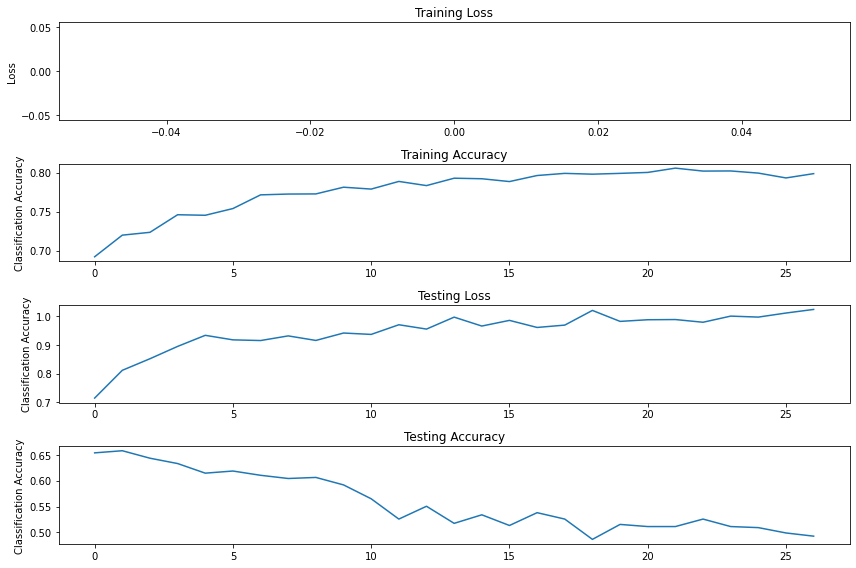

In [230]:
clf_report(train_loss, train_acc, val_loss_list, val_acc)

# Sparse + BERT -> MLP

In [256]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
pheme_sparse = scaler.fit_transform(pheme_sparse.values)
sparse_bert = np.concatenate([pheme_sparse, pheme_bert.values],axis=1)
ext_sparse = scaler.fit_transform(ext_sparse.values)
sparse_bert_ext = np.concatenate([ext_sparse, ext_bert.values],axis=1)

In [257]:
# Train = pd.concat([pheme_bert, pheme_sparse], axis=1)
# Test = pd.concat([ext_bert, ext_sparse], axis=1)

tensor_x1 = torch.Tensor(sparse_bert).unsqueeze(1)
tensor_y1 = torch.Tensor(pheme_y.values).unsqueeze(1)
train_dataset = TensorDataset(tensor_x1,tensor_y1)

tensor_x2 = torch.Tensor(sparse_bert_ext).unsqueeze(1)
tensor_y2 = torch.Tensor(ext_y.values).unsqueeze(1)
test_dataset = TensorDataset(tensor_x2,tensor_y2)

In [258]:
# Initialize WeightedRandomSampler to deal with the unbalanced dataset
counts = np.bincount(pheme_y.values)
labels_weights = 1. / counts
weights = labels_weights[pheme_y.values]
train_sampler = WeightedRandomSampler(weights, len(weights))
test_sampler = SequentialSampler(tensor_x2)

batch_size = 16

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, sampler=train_sampler, num_workers=2)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

data = next(iter(train_dataloader))
print("mean: %s, std: %s" %(data[0].mean(), data[0].std()))

train_size = int(tensor_y1.size(0))
test_size = int(tensor_y2.size(0))
print(tensor_x1.shape)
print(tensor_y1.shape)
print("Train Size",train_size,"Test Size",test_size)


mean: tensor(0.0443), std: tensor(0.3533)
torch.Size([5802, 1, 795])
torch.Size([5802, 1])
Train Size 5802 Test Size 485


In [259]:
class BERT_sparse_net(nn.Module):
    def __init__(self):
        super(BERT_sparse_net, self).__init__()  # 1*20
        self.fc1 = nn.Linear(795, 64, bias=True)  # 420
        self.fc2 = nn.Linear(64, 8, bias=True)
        self.fc3 = nn.Linear(8, 1, bias=True)

        self.drop_3 = nn.Dropout(0.3)
        self.drop_1 = nn.Dropout(0.1)
        self.drop_2 = nn.Dropout(0.2)
        self.batchnorm = nn.BatchNorm1d(64)

    def forward(self, x):
        x = self.drop_2(F.elu(self.fc1(x)))
        x = self.drop_2(F.elu(self.fc2(x)))
        x = self.fc3(x)
        return x


In [260]:
set_seed()
model_bertsparse = BERT_sparse_net()

criterion = nn.BCEWithLogitsLoss()
# optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
optimizer = optim.Adam(model_bertsparse.parameters(), lr=5e-5,eps=1e-8, weight_decay=1e-6)
# scheduler = lr_scheduler.ExponentialLR(optimizer, gamma= 0.99)  
train_loss = []
train_accuracy = []

epochs = 40

PATH = "./Model/state_dict_bert_sparse_model.pt"

scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps=0,  # Default value
                                            num_training_steps=total_steps)

In [261]:
train_acc, train_loss, val_acc, val_loss_list = train1(model=model_bertsparse, num_epochs=epochs, criterion=criterion, optimizer=optimizer, train_loader=train_dataloader, train_size=train_size, test_loader=test_dataloader, test_size=test_size, PATH=PATH)

Epoch 0/39	Train) Acc: 0.7004, Loss: 0.5906
		Validation) Acc: 0.6536 Loss:0.7409
		Saving the best model w/ loss 0.5906
		Saving the best model w/ loss 0.5422
Epoch 2/39	Train) Acc: 0.7313, Loss: 0.5318
		Validation) Acc: 0.6309 Loss:0.8584
		Saving the best model w/ loss 0.5318
		Saving the best model w/ loss 0.5015
Epoch 4/39	Train) Acc: 0.7556, Loss: 0.4978
		Validation) Acc: 0.6021 Loss:0.9358
		Saving the best model w/ loss 0.4978
		Saving the best model w/ loss 0.4959
Epoch 6/39	Train) Acc: 0.7823, Loss: 0.4799
		Validation) Acc: 0.5897 Loss:0.9303
		Saving the best model w/ loss 0.4799
		Saving the best model w/ loss 0.4790
Epoch 8/39	Train) Acc: 0.7837, Loss: 0.4816
		Validation) Acc: 0.5856 Loss:0.9257
		Saving the best model w/ loss 0.4685
Epoch 10/39	Train) Acc: 0.7858, Loss: 0.4761
		Validation) Acc: 0.5175 Loss:0.9678
		Saving the best model w/ loss 0.4636
Epoch 12/39	Train) Acc: 0.7897, Loss: 0.4708
		Validation) Acc: 0.5237 Loss:0.9668
Epoch 14/39	Train) Acc: 0.7992, Lo

In [209]:
# With 0.2-0.1 dropout
# Min of Training Loss: 0.445499
# Max of Training Accuracy: 0.810238
# Mean of Training Loss: 0.475071
# Mean of Training Accuracy: 0.783536
# ----
# Max of Testing Accuracy: 0.657732
# Mean of Testing Loss: 0.976477
# Mean of Testing Accuracy: 0.548301

# With 0.2-0.2 dropout
# Min of Training Loss: 0.450749
# Max of Training Accuracy: 0.810238
# Mean of Training Loss: 0.482355
# Mean of Training Accuracy: 0.780804
# ----
# Max of Testing Accuracy: 0.655670
# Mean of Testing Loss: 0.964116
# Mean of Testing Accuracy: 0.549828


# With 0.2-0.3 dropout
# Mean of Testing Loss: 0.959880
# Mean of Testing Accuracy: 0.555403

Min of Training Loss: 0.464161
Max of Training Accuracy: 0.784385
Mean of Training Loss: 0.500813
Mean of Training Accuracy: 0.758790
----
Max of Testing Accuracy: 0.639175
Mean of Testing Loss: 0.318642
Mean of Testing Accuracy: 0.474816

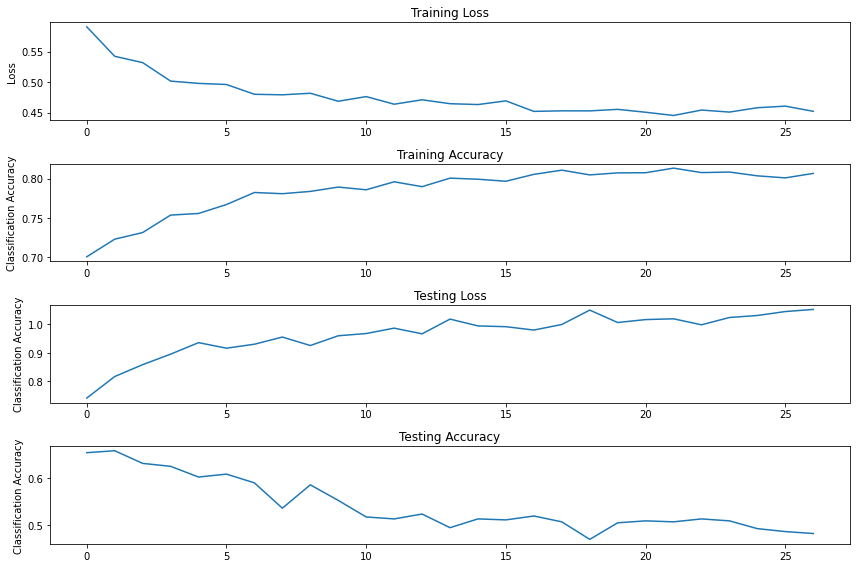

Min of Training Loss: 0.445130
Max of Training Accuracy: 0.813340
Mean of Training Loss: 0.476251
Mean of Training Accuracy: 0.785578
----
Max of Testing Accuracy: 0.657732
Mean of Testing Loss: 0.966137
Mean of Testing Accuracy: 0.541428


In [262]:
clf_report(train_loss, train_acc, val_loss_list, val_acc)


# BERT + Sparse (2)

In [267]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

pheme_sparse_scaled = scaler.fit_transform(pheme_sparse.values)
# Train = np.concatenate([train, pheme_bert.values],axis=1)

ext_sparse_scaled = scaler.fit_transform(ext_sparse.values)
# Test = np.concatenate([test, ext_bert.values],axis=1)

AttributeError: 'numpy.ndarray' object has no attribute 'values'

In [290]:
tensor_x11 = torch.Tensor(pheme_sparse.values).unsqueeze(1)
# tensor_x11 = torch.Tensor(pheme_sparse_scaled).unsqueeze(1)
tensor_x12 = torch.Tensor(pheme_bert.values).unsqueeze(1)
tensor_y1 = torch.Tensor(pheme_y.values).unsqueeze(1)
train_dataset = TensorDataset(tensor_x11, tensor_x12, tensor_y1)

tensor_x21 = torch.Tensor(ext_sparse.values).unsqueeze(1)
# tensor_x21 = torch.Tensor(ext_sparse_scaled).unsqueeze(1)
tensor_x22 = torch.Tensor(ext_bert.values).unsqueeze(1)
tensor_y2 = torch.Tensor(ext_y.values).unsqueeze(1)
test_dataset = TensorDataset(tensor_x21, tensor_x22, tensor_y2)


In [291]:
# Initialize WeightedRandomSampler to deal with the unbalanced dataset
counts = np.bincount(pheme_y.values)
labels_weights = 1. / counts
weights = labels_weights[pheme_y.values]
train_sampler = WeightedRandomSampler(weights, len(weights))
test_sampler = SequentialSampler(tensor_y2)

batch_size = 16

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, sampler=train_sampler, num_workers=2)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

data = next(iter(train_dataloader))
print("mean: %s, std: %s" %(data[0].mean(), data[0].std()))

train_size = int(tensor_y1.size(0))
test_size = int(tensor_y2.size(0))
print("Train Size",train_size,"Test Size",test_size)


mean: tensor(298.9970), std: tensor(3458.5359)
Train Size 5802 Test Size 485


In [292]:
class BERT_sparse_net2(nn.Module):
    def __init__(self):
        super(BERT_sparse_net2, self).__init__()  # 1*20

        self.layer1 = nn.Sequential(
            nn.Linear(768, 64, bias=True),  # 420
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 8, bias=True),
            nn.ReLU()
        )

        self.layer2 = nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(27, 2, bias=True),  # 420
            nn.ReLU()
            # nn.Linear(5, 2, bias=True),
            # nn.ReLU()
        )

        self.layer3 = nn.Sequential(
            nn.Linear(10, 1)  # 420
        )

        self.drop_2 = nn.Dropout(0.2)

    def forward(self, sparse, embedding):
        x1 = self.layer1(embedding)
        x2 = self.layer2(sparse)
        
        x = torch.cat((x1.squeeze(1), x2.squeeze(1)), dim=1)
        x = self.layer3(x)
        return x

In [293]:
set_seed(42)
model_bertsparse = BERT_sparse_net2()
criterion = nn.BCEWithLogitsLoss()
# optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
optimizer = optim.Adam(model_bertsparse.parameters(), lr=5e-5,eps=1e-8, weight_decay=1e-6)
# scheduler = lr_scheduler.ExponentialLR(optimizer, gamma= 0.99)  
train_loss = []
train_accuracy = []

epochs = 40

PATH = "./Model/state_dict_temp.pt"

scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps=0,  # Default value
                                            num_training_steps=total_steps)

In [301]:
def predict(model, criterion, val_dataloader, val_size):
    model.eval()
    with torch.no_grad():
        val_loss = 0.0
        val_corrects = 0
        for j, val in enumerate(val_dataloader, 0):
            val_sparse, val_embedding, val_labels = val
            val_sparse, val_embedding, val_labels = val_sparse.float(), val_embedding.float(), val_labels.float().squeeze(1)
            val_outputs = model(val_sparse, val_embedding)
            val_preds = val_outputs.squeeze(1) > 0.0

            val_preds_list.append(val_preds)
            val_label_list.append(val_labels)
            v_loss = criterion(val_outputs, val_labels.unsqueeze(1))
            val_loss += (v_loss.item() * val_labels.size(0))
            val_corrects += torch.sum(val_preds == val_labels)

    val_preds_list = torch.cat(val_preds_list, 0)
    val_label_list = torch.cat(val_label_list, 0)
    val_corrects = val_corrects/val_size
    val_loss = val_loss/val_size
    val_acc = val_corrects.double() / val_size
    print("\t\tValidation) Acc: {:.4f} Loss:{:.4f}".format(
        val_corrects/val_size, val_loss/val_size))
    # print("\t\tValidation) Acc: {:.4f} Loss:{:.4f} F1 score: {:4f}".format(val_corrects/val_size, val_loss/test_size, f1_score(val_label_list,val_preds_list,average='macro')))

def train3(model, num_epochs, criterion, optimizer, train_loader, train_size, test_loader=None, test_size=None, patience=5, PATH='./state_dict_model.pt'):
    set_seed(42)
    train_loss = []
    patience_count = 0
    train_accuracy = []
    prev_loss = 10
    best_loss = 10.0
    val_corrects_list = []
    val_loss_list = []
    val_acc_list = []
    for epoch in range(num_epochs):  # loop over the dataset multiple times
        # print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        # print('-' * 10)
        running_corrects = 0.0
        running_loss = 0.0
        model.train()  # Set model to training mode
        for i, data in enumerate(train_loader, 0):
            # get the inputs; data is a list of [inputs, labels]
            sparse, embedding, labels = data
            sparse, embedding, labels = sparse.float(), embedding.float(), labels.float().squeeze(1)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(sparse, embedding)

            #  _, predictions = torch.max(outputs.data, 1) won’t work if your output only contains a single output unit.
            # _, preds = torch.max(outputs, 1)
            # print(outputs.flatten().size())
            preds = outputs.squeeze(1) > 0.0

            loss = criterion(outputs, labels.unsqueeze(1))
            loss.backward()
            optimizer.step()

            # step function
            scheduler.step()

            running_loss += loss.item() * sparse.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / train_size
        # print(running_loss)
        # print(train_size)
        epoch_acc = running_corrects.double() / train_size
        train_loss.append(epoch_loss)
        train_accuracy.append(epoch_acc)

        if (epoch % 2 == 0):
            print('Epoch {}/{}\tTrain) Acc: {:.4f}, Loss: {:.4f}'.format(epoch,
                                                                         num_epochs - 1, epoch_acc, epoch_loss))

        if (test_loader != None):
            model.eval()
            with torch.no_grad():
                val_loss = 0.0
                val_corrects = 0
                val_preds_list = []
                val_label_list = []
                for j, val in enumerate(test_loader, 0):
                    val_sparse, val_embedding, val_labels = data
                    val_sparse, val_embedding, val_labels = val_sparse.float(), val_embedding.float(), val_labels.float().squeeze(1)
                    val_outputs = model(val_sparse, val_embedding)
                    # _, val_preds = torch.max(val_outputs, 1)
                    # print("val_outputs size:",val_outputs.size())
                    # print("val_label size:",val_label.size())
                    val_preds = val_outputs.squeeze(1) > 0.0
                    # print("pred size:",val_preds.size())

                    # print("Length of val_preds:",val_preds.size())
                    val_preds_list.append(val_preds)
                    val_label_list.append(val_labels)
                    v_loss = criterion(val_outputs, val_labels.unsqueeze(1))
                    val_loss += (v_loss.item() * val_labels.size(0))
                    val_corrects += torch.sum(val_preds == val_labels)
                    # print("== length",val_preds == val_label)
                    # accuracy = (preds == b_labels).cpu().numpy().mean() * 100

                    # print("val_corrects:",val_corrects)
                # print("length of one batch")
                # print("FINAL val_corrects:",val_corrects)
                # print("test_size:",test_size)
                    
                if (epoch % 2 == 0):
                    val_preds_list = torch.cat(val_preds_list, 0)
                    val_label_list = torch.cat(val_label_list, 0)
                    # print("\t\tValidation) Acc: {:.4f} Loss:{:.4f} F1 score: {:4f}".format(val_corrects/test_size, val_loss/test_size, f1_score(val_label_list,val_preds_list,average='macro')))
                    print("\t\tValidation) Acc: {:.4f} Loss:{:.4f}".format(
                        val_corrects/test_size, val_loss/test_size))
            val_corrects_list.append(val_corrects/test_size)
            val_loss_list.append(val_loss/test_size)
            val_acc = val_corrects.double() / test_size
            val_acc_list.append(val_acc)

        if epoch_loss < best_loss:
            # print("prev_loss: {:.5f}".format(prev_loss))
            # print("loss: {:.5f}".format(loss))
            print(
                "\t\tSaving the best model w/ loss {:.4f}".format(epoch_loss))
            torch.save(model.state_dict(), PATH)
            best_loss = epoch_loss
            patience_count = 0
        elif best_loss < epoch_loss:
            patience_count += 1
        if patience_count >= patience:
            print("Finishing the Model: Loss is not decreasing...")
            print(train_loss[-6:-1])
            return train_accuracy, train_loss, val_acc_list, val_loss_list
    return train_accuracy, train_loss, val_acc_list, val_loss_list

In [302]:
train_acc, train_loss, val_acc, val_loss_list = train3(model=model_bertsparse, num_epochs=epochs, criterion=criterion, optimizer=optimizer, train_loader=train_dataloader, train_size=train_size, test_loader=test_dataloader, test_size=test_size, PATH=PATH)

Epoch 0/39	Train) Acc: 0.7696, Loss: 0.4933
		Validation) Acc: 0.3835 Loss:0.4910
		Saving the best model w/ loss 0.4933
Epoch 2/39	Train) Acc: 0.7659, Loss: 0.4959
		Validation) Acc: 0.3835 Loss:0.3311
		Saving the best model w/ loss 0.4789
Epoch 4/39	Train) Acc: 0.7773, Loss: 0.4815
		Validation) Acc: 0.5753 Loss:0.2031
Epoch 6/39	Train) Acc: 0.7877, Loss: 0.4711
		Validation) Acc: 0.1918 Loss:0.6299
		Saving the best model w/ loss 0.4711
Epoch 8/39	Train) Acc: 0.7806, Loss: 0.4815
		Validation) Acc: 0.4474 Loss:0.3394
Epoch 10/39	Train) Acc: 0.7808, Loss: 0.4839
		Validation) Acc: 0.5753 Loss:0.2477
Finishing the Model: Loss is not decreasing...
[0.47114218840801236, 0.4734548079026481, 0.4815240962798741, 0.4728221161350716, 0.4839357735986588]


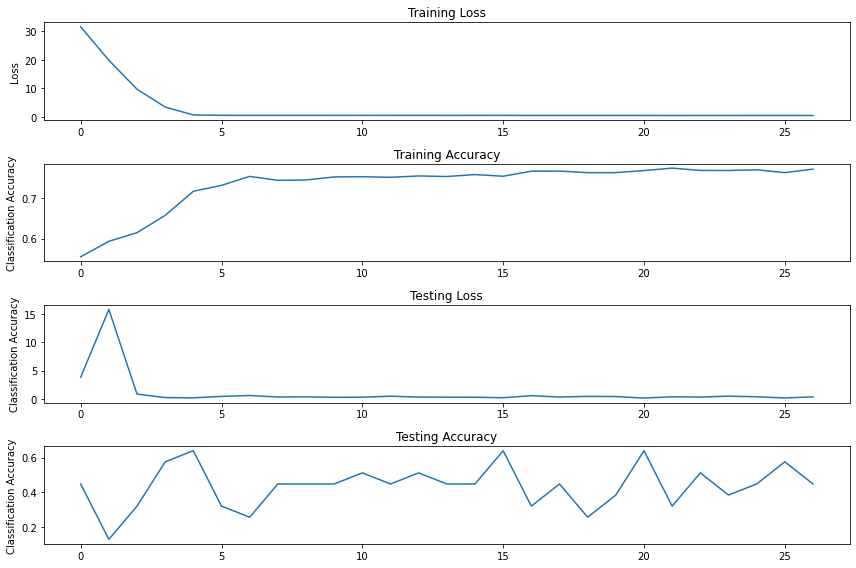

Min of Training Loss: 0.486006
Max of Training Accuracy: 0.775250
Mean of Training Loss: 2.829214
Mean of Training Accuracy: 0.735359
----
Max of Testing Accuracy: 0.639175
Mean of Testing Loss: 1.072955
Mean of Testing Accuracy: 0.435586


In [298]:
clf_report(train_loss, train_acc, val_loss_list, val_acc)

In [300]:
predict(model_bertsparse, criterion, test_dataloader, test_size)

ValueError: too many values to unpack (expected 2)

## Previous Models

self.layer1 = nn.Sequential(
    nn.Linear(768, 64, bias=True),  # 420
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(64, 8, bias=True),
    nn.ReLU()
)

self.layer2 = nn.Sequential(
    nn.Linear(27, 5, bias=True),  # 420
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(5, 2, bias=True),
    nn.ReLU()
)

self.layer3 = nn.Sequential(
    nn.Linear(10, 1)  # 420
)

Min of Training Loss: 0.471854
Max of Training Accuracy: 0.785764
Mean of Training Loss: 0.505716
Mean of Training Accuracy: 0.758512
----
Max of Testing Accuracy: 0.639175
Mean of Testing Loss: 0.351359
Mean of Testing Accuracy: 0.454525

self.layer1 = nn.Sequential(
    nn.Linear(768, 64, bias=True),  # 420
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(64, 5, bias=True),
    nn.ReLU()
)

self.layer2 = nn.Sequential(
    nn.Linear(27, 5, bias=True),  # 420
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(5, 2, bias=True),
    nn.ReLU()
)

self.layer3 = nn.Sequential(
    nn.Linear(7, 1)  # 420
)

Min of Training Loss: 0.467921
Max of Training Accuracy: 0.788694
Mean of Training Loss: 0.501997
Mean of Training Accuracy: 0.760402
----
Max of Testing Accuracy: 0.639175
Mean of Testing Loss: 0.348198
Mean of Testing Accuracy: 0.459259